In [1]:
# --- 1. Import necessary libraries ---
import pandas as pd
import xgboost as xgb
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

print("Libraries imported successfully!")

Libraries imported successfully!


In [3]:
# The path is relative to where your notebook is located
data_path = 'genetics-gold-standards/gold_standards/processed/gwas_gold_standards.191108.tsv'
gs_data = pd.read_csv(data_path, sep='\t')

print(f"Data loaded from '{data_path}'. Shape: {gs_data.shape}")

Data loaded from 'genetics-gold-standards/gold_standards/processed/gwas_gold_standards.191108.tsv'. Shape: (2435, 31)


In [6]:
print(gs_data.columns.tolist())
print(gs_data.head(10))

['association_info.ancestry', 'association_info.doi', 'association_info.gwas_catalog_id', 'association_info.neg_log_pval', 'association_info.otg_id', 'association_info.pubmed_id', 'association_info.url', 'gold_standard_info.evidence.class', 'gold_standard_info.evidence.confidence', 'gold_standard_info.evidence.curated_by', 'gold_standard_info.evidence.description', 'gold_standard_info.evidence.pubmed_id', 'gold_standard_info.evidence.source', 'gold_standard_info.gene_id', 'gold_standard_info.highest_confidence', 'metadata.comments', 'metadata.date_added', 'metadata.reviewed_by', 'metadata.set_label', 'metadata.submitted_by', 'metadata.tags', 'sentinel_variant.alleles.alternative', 'sentinel_variant.alleles.reference', 'sentinel_variant.locus_GRCh37.chromosome', 'sentinel_variant.locus_GRCh37.position', 'sentinel_variant.locus_GRCh38.chromosome', 'sentinel_variant.locus_GRCh38.position', 'sentinel_variant.rsid', 'trait_info.ontology', 'trait_info.reported_trait_name', 'trait_info.standa

In [7]:
# --- 1. Define New Features and Target ---
# We select columns that exist in your new data file
features = [
    'association_info.neg_log_pval',
    'sentinel_variant.locus_GRCh37.position'
]

# Our new target column is the confidence level
target_col = 'gold_standard_info.evidence.confidence'

print("Using new features and target.")

# --- 2. Preprocessing ---
# Create a dataframe with only the columns we need
model_df = gs_data[features + [target_col]].copy()

# Handle missing values in numeric feature columns
model_df.fillna(0, inplace=True)

# Create a binary target variable: 1 if confidence is 'High', 0 otherwise
# This is what our model will try to predict
model_df['target'] = (model_df[target_col] == 'High').astype(int)

print("Data preprocessed successfully. Target 'High' confidence is mapped to 1.")

Using new features and target.
Data preprocessed successfully. Target 'High' confidence is mapped to 1.


In [8]:
# --- 3. Split Data and Train the XGBoost model ---
# Use the new features and the new binary 'target' column
X = model_df[features]
y = model_df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

l2g_model = xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss')
l2g_model.fit(X_train, y_train)

print("XGBoost model trained successfully!")

XGBoost model trained successfully!


C:\Users\epcm\anaconda3\envs\xai_env\lib\site-packages\xgboost\core.py:158: UserWarning: [12:33:06] WARNING: D:\bld\xgboost-split_1744329010901\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [11]:
# --- 4. Save the trained model and test data ---
model_filename = 'l2g_xgboost_model.joblib'
joblib.dump(l2g_model, model_filename)

X_test.to_csv('X_test_data.csv', index=False)
y_test.to_csv('y_test_data.csv', index=False)

print(f"Trained model saved to '{model_filename}'")
print("Test data saved for later use.")
print("\nSetup complete! You are now ready for the XAI analysis.")

Trained model saved to 'l2g_xgboost_model.joblib'
Test data saved for later use.

Setup complete! You are now ready for the XAI analysis.


# Loading Saved Model

In [1]:
import joblib
import pandas as pd
from sklearn.metrics import accuracy_score

In [2]:
# Load the saved XGBoost model
model = joblib.load('l2g_xgboost_model.joblib')

# Load test features and labels
X_test = pd.read_csv('X_test_data.csv')
y_test = pd.read_csv('y_test_data.csv')

c:\Users\rwkos\miniconda3\envs\bioinfo\Lib\pickle.py:1760: UserWarning: [12:51:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\data\../common/error_msg.h:82: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  setstate(state)


In [6]:
X_test

,association_info.neg_log_pval,sentinel_variant.locus_GRCh37.position
0,13.000000,72433098
1,18.522879,12393125
2,15.979639,139942304
3,12.045757,118184783
4,7.522879,108618630
...,...,...
482,9.698970,44324727
483,8.000000,100298984
484,9.000000,15064309
485,9.522879,86427626


In [5]:
y_test

,target
0,0
1,0
2,0
3,1
4,1
...,...
482,1
483,0
484,0
485,0


In [3]:
# Predict on test data
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.7454


In [7]:
y_pred

array([0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1,

# SHAP

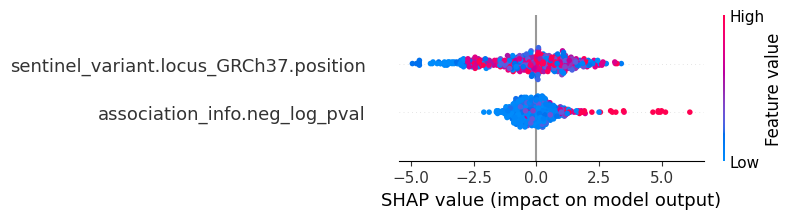

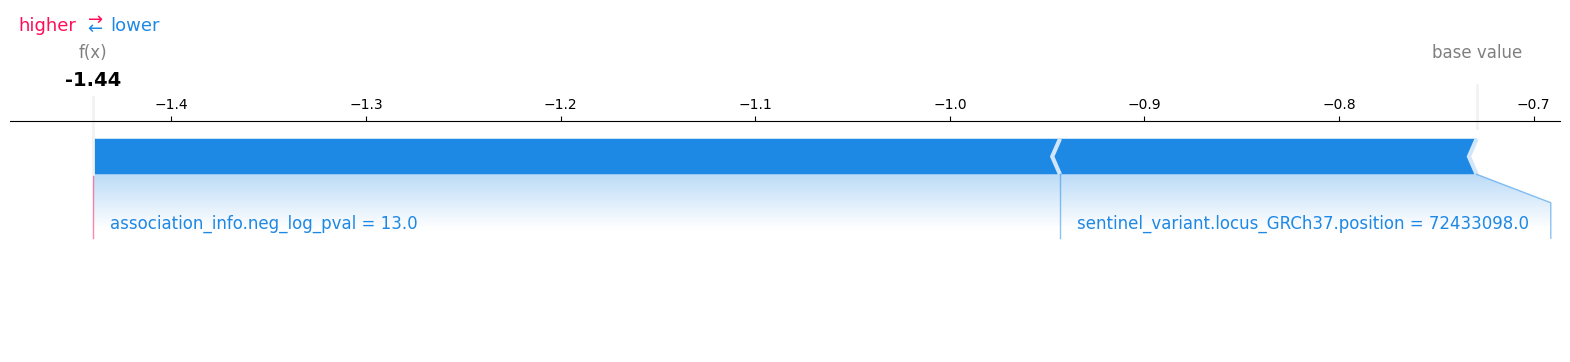

In [9]:
import shap
import pandas as pd

# Load test data
X_test = pd.read_csv("X_test_data.csv")

# Create a SHAP explainer
explainer = shap.Explainer(model)  # Works directly with XGBClassifier
shap_values = explainer(X_test)

# Summary plot (global feature importance)
shap.summary_plot(shap_values, X_test)

# Force plot for a single prediction (local explanation)
shap.plots.force(shap_values[0],matplotlib=True)